# Data Analytics

We seek to analyse the format of the input dataset, of the SQL queries at hand and obviously determine causalities between input queries and execution time.

## Part 0: Imports

In [1]:
import pandas as pd

## Part 1: Exploring the datasets

In this notebook Pandas will be adopted as a data exploration tool.

In [2]:
general_log_df = pd.read_json("data/general_log.json")
slow_log_df = pd.read_json("data/slow_log.json")

In [3]:
general_log_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16101 entries, 0 to 16100
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   event_time    16101 non-null  datetime64[ns]
 1   user_host     16101 non-null  object        
 2   thread_id     16101 non-null  int64         
 3   server_id     16101 non-null  int64         
 4   command_type  16101 non-null  object        
 5   argument      16101 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 754.9+ KB


In [4]:
slow_log_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15688 entries, 0 to 15687
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   start_time      15688 non-null  datetime64[ns]
 1   user_host       15688 non-null  object        
 2   query_time      15688 non-null  datetime64[ns]
 3   lock_time       15688 non-null  datetime64[ns]
 4   rows_sent       15688 non-null  int64         
 5   rows_examined   15688 non-null  int64         
 6   db              15688 non-null  object        
 7   last_insert_id  15688 non-null  int64         
 8   insert_id       15688 non-null  int64         
 9   server_id       15688 non-null  int64         
 10  sql_text        15688 non-null  object        
 11  thread_id       15688 non-null  int64         
dtypes: datetime64[ns](3), int64(6), object(3)
memory usage: 1.4+ MB


The two dataframes have different schemas: slow_log_df also contains some information about the database lock time, the number of rows that have been somehow manipulated and other debugging information. The semantically common columns still have different names (e.g. event_time vs start_time/query_time).

Let us have a look on the statistics of numerical columns for slow_log_df.

To satisfy our curiosity, let us see which values appear in the `db` and `*_id` columns.

In [5]:
print(slow_log_df["db"].unique())
print(slow_log_df["server_id"].unique())
print(slow_log_df["thread_id"].unique())
print(slow_log_df["insert_id"].unique())
print(slow_log_df["last_insert_id"].unique())

['tpch' '']
[97408076]
[67  9 66 65 63 64 62 61 60 59 58 57 40 56 55 54 53 52 51 50 49 48 47 46
 45 44 43 42 41 39 38 37 36 35 34 33 20 32 31 30 29 28 27 26 25 24 23 22
 21 19 18 14]
[0]
[0]


As it turns out, the records above are not quite useful. We thus drop them and consider the following:

- `query_time`
- `lock_time`
- `rows_sent`
- `rows_examined`
- `sql_text`

In [6]:
slow_log_df["query_time"].dt.microsecond

0            93
1            55
2            76
3           138
4            90
          ...  
15683        74
15684       147
15685        91
15686       102
15687    181089
Name: query_time, Length: 15688, dtype: int64

In [7]:
numerical_cols = ["query_time", "lock_time", "rows_sent",
                  "rows_examined", "sql_text"]

# convert datetime64 into int
slow_log_numerical_df = slow_log_df[numerical_cols]
slow_log_numerical_df["query_time_int"] = slow_log_numerical_df["query_time"].dt.microsecond
slow_log_numerical_df["lock_time_int"] = slow_log_numerical_df["lock_time"].dt.microsecond
slow_log_numerical_df = slow_log_numerical_df.drop(["query_time", "lock_time"], axis=1)

slow_log_numerical_df.describe(datetime_is_numeric=True)

<ipython-input-7-31917f1af7f2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slow_log_numerical_df["query_time_int"] = slow_log_numerical_df["query_time"].dt.microsecond
<ipython-input-7-31917f1af7f2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slow_log_numerical_df["lock_time_int"] = slow_log_numerical_df["lock_time"].dt.microsecond


,rows_sent,rows_examined,query_time_int,lock_time_int
count,15688.000000,1.568800e+04,15688.000000,15688.000000
mean,8554.359574,6.093278e+05,144810.271800,155.016382
std,32730.257214,1.253887e+06,232662.161443,931.420305
min,0.000000,0.000000e+00,7.000000,0.000000
25%,1.000000,1.000000e+00,442.000000,0.000000
50%,1.000000,1.000000e+00,1299.500000,72.000000
75%,31.250000,3.415950e+05,227597.750000,177.000000
max,241191.000000,4.501838e+06,999952.000000,71033.000000


A lot can be said right now:
    
- There is a wild excursion in rows_sent: the minimum is 0, the maximum is 241191, the standard deviation is roughly 32,000. Similar numbers apply to rows_examined
- query time ranges from 7 microseconds to 999952 microseconds, i.e. almost an entire second.
- These times are heavily unbalanced: for what concerns query_time_int the 25% percentile is just 442 us, the 50% is barely 13000 us (13 ms), the 75% 228 ms.
- Lock time seems less useful as it seems "small" (in the order of a few microseconds) for the 75% percentile, but has an outlier of 71 ms.

A good guess is that the huge loading times are due to many rows being manipulated (this still _ignores_ the causes for that). In a few cells, we will prove this hypothesis.

A plot will be more convincing

(array([1.5401e+04, 2.2100e+02, 1.3000e+01, 5.0000e+00, 3.0000e+00,
        2.0000e+00, 4.0000e+00, 1.0000e+00, 8.0000e+00, 2.0000e+00,
        2.0000e+00, 3.0000e+00, 2.0000e+00, 7.0000e+00, 2.0000e+00,
        2.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

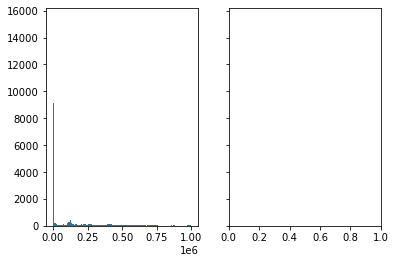

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# make a histogram on bucketised frequency

fig, axs = plt.subplots(1, 2, sharey=True)
# bins = np.linspace(0, 1_000_000)
axs[0].hist(slow_log_numerical_df["query_time_int"], bins=100)
axs[0].hist(slow_log_numerical_df["lock_time_int"], bins=100)

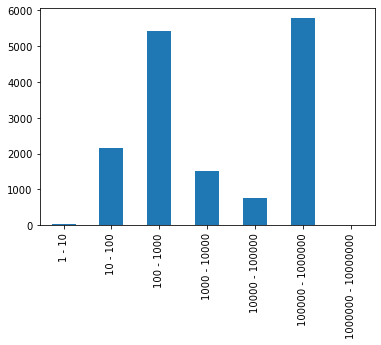

In [9]:
# the plots above are unreadable! let us show a log plot.

def make_log_plot(series, base=10):
    exp = int(np.ceil(np.log(series.max()) / np.log(base)))
    bins=[int(x) for x in np.geomspace(1, base**(exp+1), exp+2)]

    labels = ["{} - {}".format(left, left*base) for left in bins]
    log_freqs = pd.cut(series, bins, labels=labels[:-1]).value_counts()

    log_freqs.sort_index().plot(kind="bar")

make_log_plot(slow_log_numerical_df["query_time_int"])

The time distribution shows two peaks: the times between 100 us and 1ms, and the times 100,000 us and 1,000,000 us (100 ms and 1s, respectively). Quite obviously, the data does not look sampled from a normal distribution.

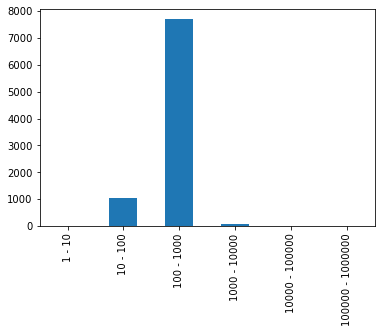

In [10]:
make_log_plot(slow_log_numerical_df["lock_time_int"], base=10)

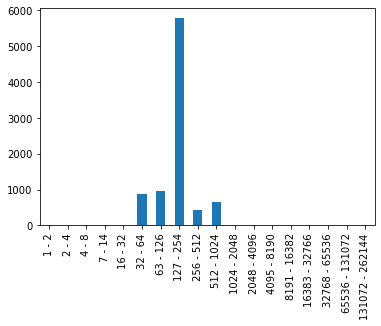

In [11]:
# More granular
make_log_plot(slow_log_numerical_df["lock_time_int"], base=2)

We confirm the suspect nurtured above about `lock_time`: the times seem centered around 254 us. The distribution is normal-like with relatively short tails, as to be expected.

In [12]:
log_numerical_df = slow_log_numerical_df.drop(["lock_time_int"], axis=1)
log_numerical_df.describe()

,rows_sent,rows_examined,query_time_int
count,15688.000000,1.568800e+04,15688.000000
mean,8554.359574,6.093278e+05,144810.271800
std,32730.257214,1.253887e+06,232662.161443
min,0.000000,0.000000e+00,7.000000
25%,1.000000,1.000000e+00,442.000000
50%,1.000000,1.000000e+00,1299.500000
75%,31.250000,3.415950e+05,227597.750000
max,241191.000000,4.501838e+06,999952.000000


Let us use Pearson's Correlation test to determine how much `rows_examined` and `query_time_int` are used.

In [15]:
import scipy.stats

scipy.stats.pearsonr(log_numerical_df["rows_examined"], log_numerical_df["query_time_int"])

(0.5968870258290725, 0.0)

The correlation seems existing, although not fully linear.

## Part 2: SQL query format

We can now inspect the big elephant in the room: the SQL queries.

In [19]:
log_numerical_df["sql_text"].head(50)

0     /* ApplicationName=DataGrip 2020.2.3 */ SET ne...
1                                         SHOW WARNINGS
2                                         SHOW WARNINGS
3     /* ApplicationName=DataGrip 2020.2.3 */ select...
4     /* ApplicationName=DataGrip 2020.2.3 */ SET SQ...
5                                         SHOW WARNINGS
6                SELECT @@session.transaction_read_only
7     /* ApplicationName=DataGrip 2020.2.3 */ set se...
8                SELECT @@session.transaction_isolation
9                                                  Ping
10                                                 Ping
11                                                 Ping
12                            SELECT @@GLOBAL.read_only
13                                             SELECT 1
14               SELECT value FROM mysql.rds_heartbeat2
15                                             SELECT 1
16    SELECT count(*) from information_schema.TABLES...
17                                             S